# Self-Driving Car Engineer Nanodegree

## Project 5: Vehicle Detection and Tracking

#### Note
1. Where sections are numbered the numbering follows the numbers assigned to the rubric points in the accompanying writeup.
2. This notebook contains code adapted from Udacity course material.

### Prelude

In [45]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from time import time
from glob import glob
from tqdm import tqdm
from pprint import pformat
from collections import deque, namedtuple
from distutils.version import StrictVersion

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

print("OpenCV version:", cv2.__version__)

if StrictVersion(cv2.__version__) < StrictVersion("3.1.0"):
    print("ERROR: OpenCV version 3.1.0 or greater required.")
    del cv2

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
matplotlib.rc('figure', figsize=(14, 7))


def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    assert img is not None
    return img


def show_image(img, axis=plt, title=None):
    print("Image '{}' dtype: {}, shape:{}, min val:{}, max val:{}, mean:{:.2f}, stddev:{:.2f}"
            .format(title, img.dtype, img.shape, np.min(img), 
                    np.max(img), np.mean(img), np.std(img)))
    if len(img.shape) == 2:
        axis.imshow(img, cmap='gray')
    elif len(img.shape) > 2:
        axis.imshow(img)
        
    if title:
        if axis is plt:
            axis.title(title)
        else:
            axis.set_title(title)

            
def cvt_color(image, cspace):
    if cspace is None:
        return np.copy(image)
    
    if cspace == 'YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    if cspace == 'gray':
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if cspace == 'RGB':
        return cv2.cvtColor(image, cv2.COLOR_RGB2RGB)

    if cspace == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    if cspace == 'LUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    
    if cspace == 'HLS':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    if cspace == 'YUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    raise Exception("'{}' colorspace not supported.".format(cspace))

OpenCV version: 3.1.0


### B.1: Feature extraction

Image 'Sample vehicle image' dtype: uint8, shape:(64, 64, 3), min val:7, max val:230, mean:53.63, stddev:44.26
Image 'Sample non-vehicle image' dtype: uint8, shape:(64, 64, 3), min val:29, max val:110, mean:59.07, stddev:12.27


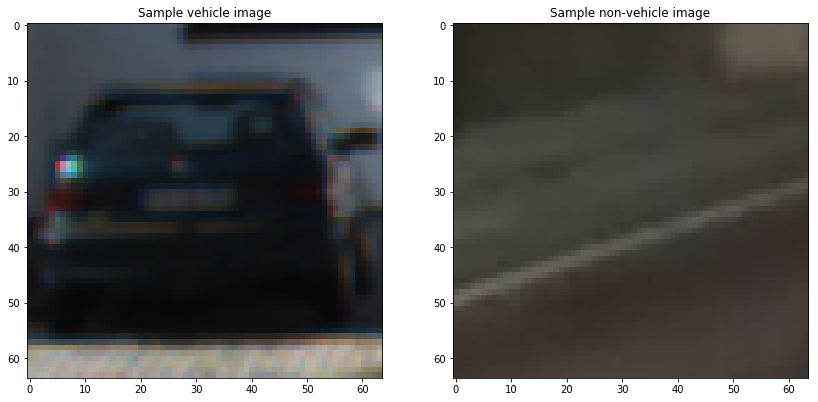

In [2]:
# Load training data

vehicle_image_paths = glob("untracked/training_data/vehicles/**/*")
non_vehicle_image_paths = glob("untracked/training_data/non-vehicles/**/*")

fig, axes = plt.subplots(1,2)

img = load_image(vehicle_image_paths[0])
show_image(img, axes[0], "Sample vehicle image")

img = load_image(non_vehicle_image_paths[0])
show_image(img, axes[1], "Sample non-vehicle image")

fig.savefig("output_images/sample_input.jpg")



In [3]:
# Define a function to return HOG features and visualization
def get_hog_features_1ch(img, orientations, pixels_per_cell, cells_per_block, 
                     feature_vector=True, visualise=False, transform_sqrt=False):
        result = hog(img, 
                     orientations=orientations,
                     pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                     cells_per_block=(cells_per_block, cells_per_block), 
                     transform_sqrt=transform_sqrt,
                     visualise=visualise,
                     feature_vector=feature_vector,
                     block_norm='L2-Hys')
        return result

In [4]:
def get_hog_features(image, hog_channel):

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(image.shape[2]):
            hog_features.extend(get_hog_features_1ch(image[...,channel], 
                                          orientations=ORIENTATIONS, 
                                          pixels_per_cell=PIXELS_PER_CELL, 
                                          cells_per_block = CELLS_PER_BLOCK))      
    else:
        if  len(image.shape) >= 3:
            image = image[...,hog_channel]
        
        hog_features = get_hog_features_1ch(image, 
                                      orientations=ORIENTATIONS, 
                                      pixels_per_cell=PIXELS_PER_CELL, 
                                      cells_per_block = CELLS_PER_BLOCK)

    return np.array(hog_features)

In [5]:
def visualize_hog_features_1ch(base_img, cspace, axis=None):
    img = cvt_color(base_img, cspace)
    
    if len(img1.shape) > 2:
        if axis is None:
            fig, axis = plt.subplots(1, img.shape[2]+1)
        
        show_image(base_img, axis[0], "Base image")
        
        for ch in range(img.shape[2]):
            hf = get_hog_features_1ch(img[...,ch],
                                      orientations=ORIENTATIONS, 
                                      pixels_per_cell=PIXELS_PER_CELL, 
                                      cells_per_block = CELLS_PER_BLOCK,
                                      visualise=True, feature_vector=False)
            show_image(hf[1], axis[1+ch], "HOG of Ch.: {}".format(ch))
    else:
        if axis is None:
            fig, axis = plt.subplots(1, img.shape[2])

        show_image(base_img, axis[0], "Base image")
        show_image(img, axis[1], "Gray scale image")

        hf = get_hog_features_1ch(img,
                                  orientations=ORIENTATIONS, 
                                  pixels_per_cell=PIXELS_PER_CELL, 
                                  cells_per_block = CELLS_PER_BLOCK,
                                  visualise=True, feature_vector=False)
        show_image(hf[1], axis[2], "HOG")


In [6]:
# HOG Params
HOG_COLOR_SPACE = 'YCrCb'
ORIENTATIONS = 32
PIXELS_PER_CELL = 16
CELLS_PER_BLOCK = 2
HOG_CHANNELS = "ALL" # Can be 0, 1, 2, or "ALL"
HIST_BINS=32
SPATIAL_SIZE=(32,32)


YCrCb untracked/training_data/vehicles/KITTI_extracted/3463.png
type: <class 'numpy.ndarray'>
Image 'Base image' dtype: uint8, shape:(64, 64, 3), min val:6, max val:255, mean:85.28, stddev:64.11
Image 'YCrCb Ch.: 0' dtype: uint8, shape:(64, 64), min val:8, max val:255, mean:83.95, stddev:61.88
Image 'YCrCb Ch.: 1' dtype: uint8, shape:(64, 64), min val:71, max val:213, mean:126.54, stddev:12.03
Image 'YCrCb Ch.: 2' dtype: uint8, shape:(64, 64), min val:74, max val:196, mean:131.51, stddev:12.02
Image 'Base image' dtype: uint8, shape:(64, 64, 3), min val:6, max val:255, mean:85.28, stddev:64.11
Image 'HOG of Ch.: 0' dtype: float64, shape:(64, 64), min val:0.0, max val:28.09146201238036, mean:1.04, stddev:2.46
Image 'HOG of Ch.: 1' dtype: float64, shape:(64, 64), min val:0.0, max val:6.470962852239609, mean:0.31, stddev:0.56
Image 'HOG of Ch.: 2' dtype: float64, shape:(64, 64), min val:0.0, max val:6.206480339169502, mean:0.34, stddev:0.62


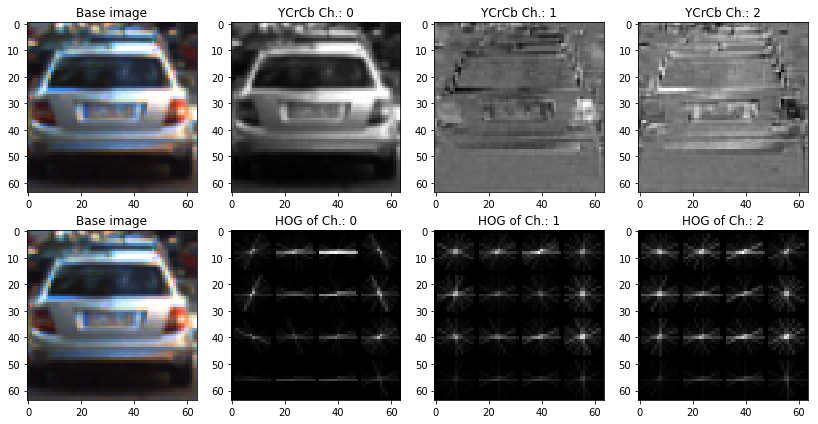

YCrCb untracked/training_data/non-vehicles/GTI/image2652.png
type: <class 'numpy.ndarray'>
Image 'Base image' dtype: uint8, shape:(64, 64, 3), min val:25, max val:99, mean:51.91, stddev:9.68
Image 'YCrCb Ch.: 0' dtype: uint8, shape:(64, 64), min val:30, max val:94, mean:53.50, stddev:8.81
Image 'YCrCb Ch.: 1' dtype: uint8, shape:(64, 64), min val:119, max val:132, mean:125.14, stddev:1.78
Image 'YCrCb Ch.: 2' dtype: uint8, shape:(64, 64), min val:113, max val:130, mean:125.94, stddev:3.42
Image 'Base image' dtype: uint8, shape:(64, 64, 3), min val:25, max val:99, mean:51.91, stddev:9.68
Image 'HOG of Ch.: 0' dtype: float64, shape:(64, 64), min val:0.0, max val:4.520915070548654, mean:0.15, stddev:0.48
Image 'HOG of Ch.: 1' dtype: float64, shape:(64, 64), min val:0.0, max val:0.6248014802113175, mean:0.03, stddev:0.07
Image 'HOG of Ch.: 2' dtype: float64, shape:(64, 64), min val:0.0, max val:0.9369094269350171, mean:0.03, stddev:0.09


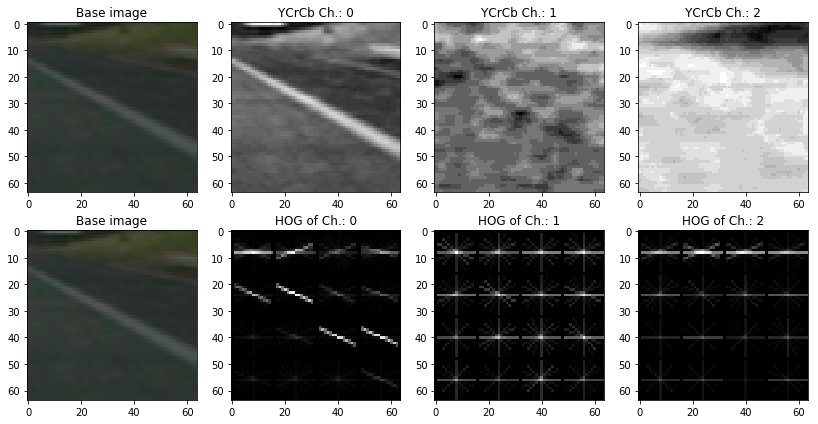

In [8]:
from itertools import chain
for cspace in ['YCrCb']: #[None, 'gray', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
    for i, img_path in enumerate(chain(vehicle_image_paths[15:16], non_vehicle_image_paths[15:16])):
        print(cspace, img_path)
        img = load_image(img_path)
        img1 = cvt_color(img, cspace)
        print("type:", type(img))
        
        if len(img1.shape) > 2:
            fig, axes = plt.subplots(2, img1.shape[2]+1)

            show_image(img, axes[0,0], "Base image")
            
            for ch in range(img.shape[2]):
                show_image(img1[...,ch], axes[0,1+ch], "{} Ch.: {}".format(cspace, ch))
            
            visualize_hog_features_1ch(img, cspace, axes[1])
            fig.savefig("output_images/sample_hog_viz{}.jpg".format(i+1))
        else:
            fig, axes = plt.subplots(1, 3)

            show_image(img, axes[0], "Base image")

            visualize_hog_features_1ch(img, cspace, axes[1])
            fig.savefig("output_images/sample_hog_viz{}.jpg".format(i+1))
        plt.show()


In [9]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(img):
    img = cvt_color(img, HOG_COLOR_SPACE)
    
    spatial_features = bin_spatial(img, size=SPATIAL_SIZE)
    hist_features = color_hist(img, nbins=HIST_BINS)
    hog_features = get_hog_features(img, hog_channel=HOG_CHANNELS)
    
    features = np.hstack((spatial_features, hist_features, hog_features))
    return features


def get_features_from_images(image_paths, cspace, hog_channel):
    all_features = []
    for img_path in tqdm(image_paths):
        img = load_image(img_path)
        all_features.append(extract_features(img))
        del img
    return np.array(all_features)
        

#### Extract features

In [10]:
# Extract features
t = time()

vehicle_features = get_features_from_images(vehicle_image_paths, HOG_COLOR_SPACE, HOG_CHANNELS)
print("vehicle_features.shape:", vehicle_features.shape)
print("vehicle_features[0].shape:", vehicle_features[0].shape)

non_vehicle_features = get_features_from_images(non_vehicle_image_paths, HOG_COLOR_SPACE, HOG_CHANNELS)
print("non_vehicle_features.shape:", non_vehicle_features.shape)

t1 = time()
print('{:.2f} seconds to extract features.'.format(t1-t))

  0%|          | 19/8968 [00:00<00:47, 187.19it/s]

vehicle_features.shape: (8792, 6624)
vehicle_features[0].shape: (6624,)


100%|██████████| 8968/8968 [00:48<00:00, 186.66it/s]


non_vehicle_features.shape: (8968, 6624)
96.26 seconds to extract features.


### B.2: Classifier training

In [11]:
# Prepare classifier input
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print("X.shape:", X.shape)
# Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
X_scaler = RobustScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

del vehicle_features
del non_vehicle_features


X.shape: (17760, 6624)


In [104]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
print()
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [105]:
print('Using:', ORIENTATIONS,'orientations', PIXELS_PER_CELL,
    'pixels per cell and', CELLS_PER_BLOCK,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 6624


In [106]:
# Use a linear SVC 
svc = LinearSVC(C=10)
# Check the training time for the SVC
t = time()
svc.fit(X_train, y_train)
t1 = time()
print('{:.2f} seconds to train SVC.'.format(t1-t))


9.60 seconds to train SVC.


In [107]:
# Check score
print('Train accuracy of SVC = {:.4f}'.format(svc.score(X_train, y_train)))
print('Test accuracy of SVC = {:.4f}'.format(svc.score(X_test, y_test)))
# Check the prediction time for a single sample
n_predict = 10
t = time()
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t1 = time()
print('{:.5f} seconds to predict {} labels with SVC.'.format(t1-t, n_predict))

Train accuracy of SVC = 1.0000
Test accuracy of SVC = 0.9938
My SVC predicts:  [ 0.000  1.000  0.000  1.000  0.000  0.000  1.000  0.000  0.000  0.000]
For these 10 labels:  [ 0.000  1.000  0.000  1.000  0.000  0.000  1.000  0.000  0.000  0.000]
0.00175 seconds to predict 10 labels with SVC.


In [109]:
# Save classifier to disk
with open("classifier.p", "wb") as f:
    obj = {"classifier": svc, "scaler": X_scaler}
    pickle.dump(obj, f)

### C.1: Sliding window search


In [110]:
# Reload classifier from disk
with open("classifier.p", "rb") as f:
    obj = pickle.load(f)
    clf = obj["classifier"]
    scaler = obj["scaler"]

In [111]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    img_tosearch = img[ystart:ystop,:,:]

    ctrans_tosearch = cvt_color(img_tosearch, 'YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                        (np.int(imshape[1]/scale), 
                                         np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features_1ch(ch1, orientations=ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL, 
                                cells_per_block=CELLS_PER_BLOCK, feature_vector=False)
    hog2 = get_hog_features_1ch(ch2, orientations=ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL, 
                                cells_per_block=CELLS_PER_BLOCK, feature_vector=False)
    hog3 = get_hog_features_1ch(ch3, orientations=ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL, 
                                cells_per_block=CELLS_PER_BLOCK, feature_vector=False)
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features))
                                             .reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),2) 
                windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return windows


def draw_windows(img, windows):
    img1 = np.copy(img)
    for pt1, pt2 in windows:
        cv2.rectangle(img1, pt1, pt2, (0, 0, 255), 2)
    return img1

params=[
    (380, 550, 0.6),
    (400, 656, 0.7), 
    (400, 656, 0.8), 
    (400, 656, 0.9), 
    (400, 656, 1.2),
    (400, 656, 1.4),
    (400, 656, 1.6),
    (400, 656, 1.8),
    (400, 656, 2), 
    (400, 656, 2.2), 
    (400, 656, 2.4), 
    (400, 656, 2.6), 
]

def find_cars_at_multiple_scales(img, params):
    windows = []
    for ystart, ystop, scale in params:
        windows.extend(find_cars(img, ystart, ystop, scale, clf, scaler,
                        orient=ORIENTATIONS, pix_per_cell=PIXELS_PER_CELL, 
                        cell_per_block=CELLS_PER_BLOCK,
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS))
    return windows

import os.path

### C.2. Sample images demonstrating the pipeline

Finding cars in:  test_images/test3.jpg
Image 'None' dtype: uint8, shape:(720, 1280, 3), min val:0, max val:255, mean:115.59, stddev:50.84


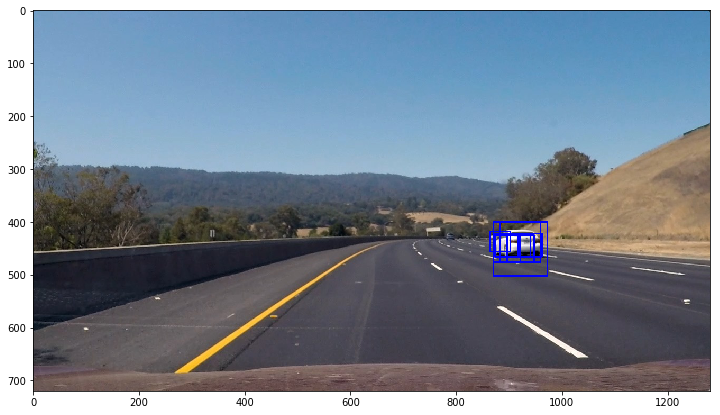

Finding cars in:  test_images/test4.jpg
Image 'None' dtype: uint8, shape:(720, 1280, 3), min val:0, max val:255, mean:121.14, stddev:63.73


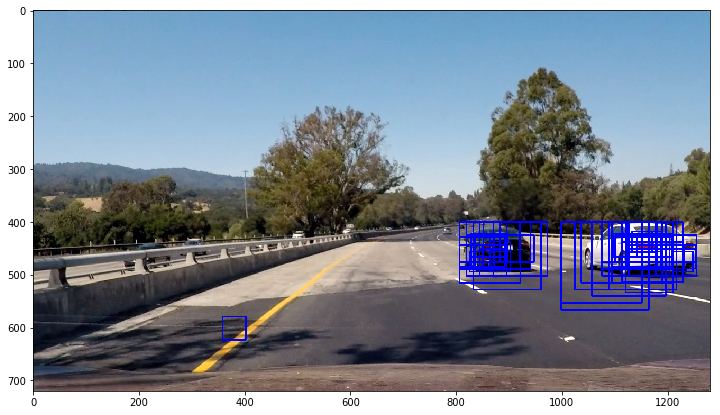

Finding cars in:  test_images/test6.jpg
Image 'None' dtype: uint8, shape:(720, 1280, 3), min val:0, max val:255, mean:102.19, stddev:57.41


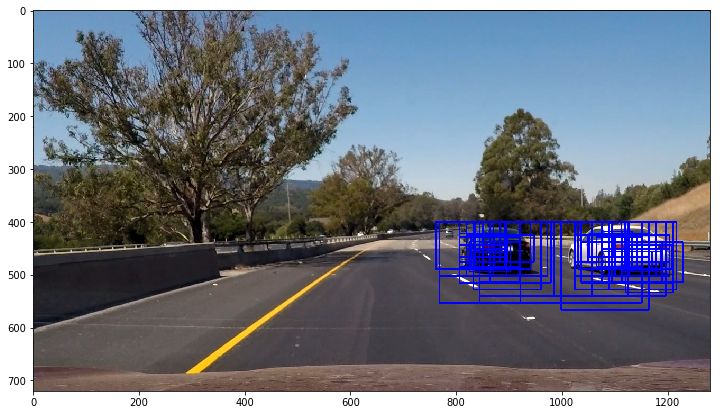

In [112]:
def demo_find_cars():
    for img_path in ["test3.jpg", "test4.jpg", "test6.jpg"]:
        input_path = os.path.join("test_images", img_path)
        print("Finding cars in: ", input_path)
        test_img = load_image(input_path)
        windows = find_cars_at_multiple_scales(test_img, params)
        out_img = draw_windows(test_img, windows)
        show_image(out_img)
        output_path = os.path.join("output_images", "post_detection_"+img_path)
        plt.savefig(output_path)
        plt.show()
        
demo_find_cars()

### D.2. Removing false positives

Processing: test_images/heatmap_frames/01.png


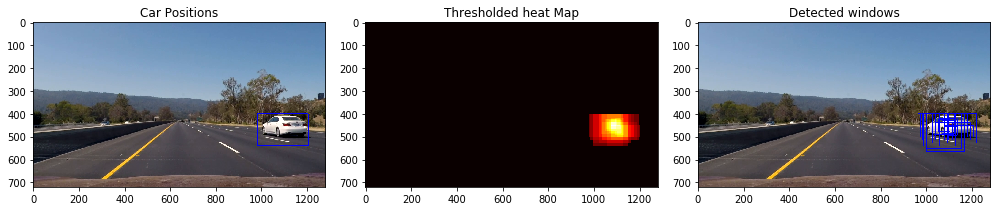

Processing: test_images/heatmap_frames/02.png


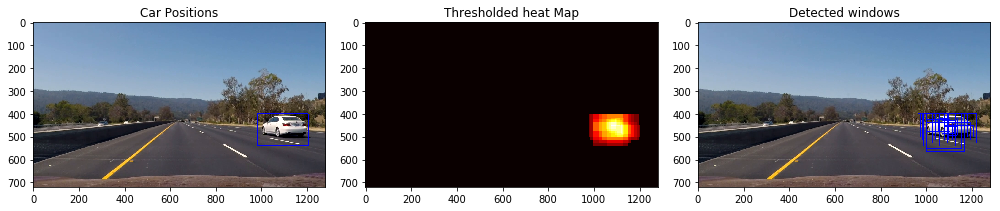

Processing: test_images/heatmap_frames/03.png


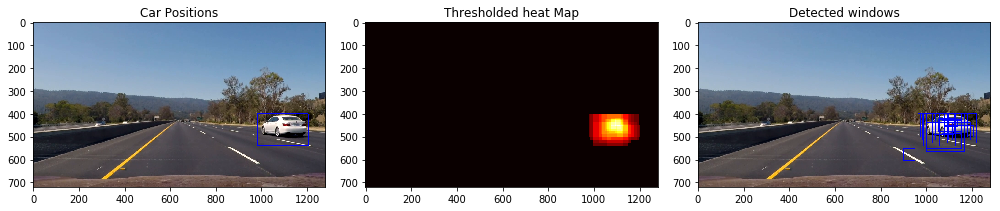

Processing: test_images/heatmap_frames/04.png


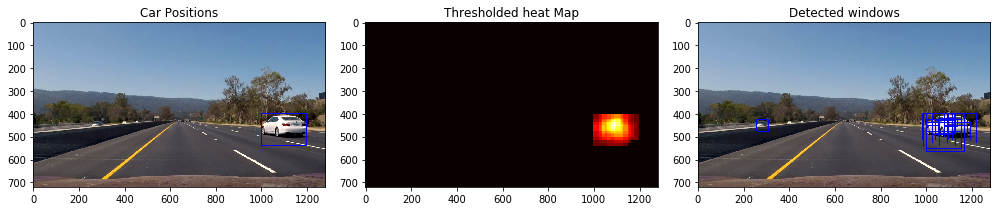

Processing: test_images/heatmap_frames/05.png


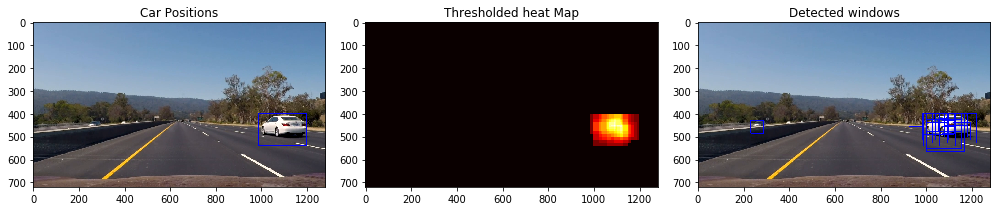

Processing: test_images/heatmap_frames/06.png


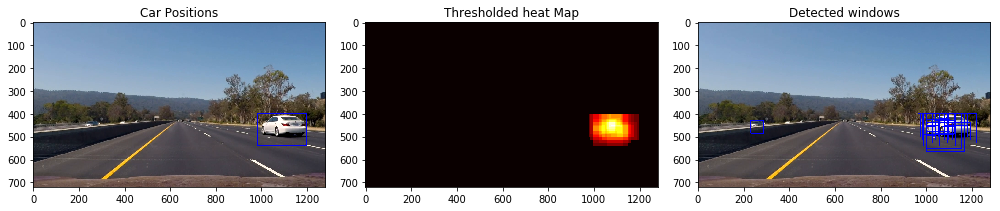

In [113]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 2)
    # Return the image
    return img


def init_heatmap(img):
    heat = np.zeros_like(img[...,0]).astype(np.float)
    return heat

def label_cars(img, heatmap, threshold):
    # Find cars at multiple scales
    windows = find_cars_at_multiple_scales(img, params)
    
    # Add heat to each box in box list
    heatmap = add_heat(heatmap, windows)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    return labels, windows

# t = time()
# t1 = time()
# print('Time taken for finding car\'s in one frame: {:.2f}'.format(t1-t))

for i in range(1, 7):
    img_path = "test_images/heatmap_frames/{:02}.png".format(i)
    print("Processing:", img_path)
    img = load_image(img_path)
    heatmap = init_heatmap(img)
    labels, windows = label_cars(img, heatmap, threshold=2)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 3))
    axes[0].imshow(draw_img)
    axes[0].set_title('Car Positions')
    axes[1].imshow(heatmap, cmap='hot')
    axes[1].set_title('Thresholded heat Map')
    axes[2].imshow(draw_windows(img, windows))
    axes[2].set_title('Detected windows')
    fig.tight_layout()
    fig.savefig("output_images/heatmap_frames/{:02}.jpg".format(i))
    plt.show()
    
    


In [114]:
frame_no = 0
heatmap = init_heatmap(img)

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    global frame_no
    global heatmap
    
    THRESHOLD = 3
    
    if frame_no == THRESHOLD:
        heatmap = init_heatmap(img)
        frame_no = 0
        
    labels, _ = label_cars(img, heatmap, threshold=THRESHOLD)
    out_img = draw_labeled_bboxes(np.copy(img), labels)
    frame_no += 1
    return out_img

In [115]:
# Adapted from Udacity sample code
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

if not os.path.exists('output_videos'):
    os.makedirs('output_videos')

project_output = 'output_videos/project_video_annotated.mp4'


In [116]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(23, 24)

visualize = False
clip1_1 = clip1.fl_image(process_image) # NOTE: this function expects color images!!
%time clip1_1.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_annotated.mp4
[MoviePy] Writing video output_videos/project_video_annotated.mp4


 96%|█████████▌| 25/26 [01:55<00:04,  4.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_annotated.mp4 

CPU times: user 2min 3s, sys: 176 ms, total: 2min 4s
Wall time: 1min 55s


In [117]:
from IPython.core.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))
